1. Get train data and test data
2. Split train data (train, eval) right away to simulate train vs test data
3. Handle missing values (na and 'insert')
4. Handle outliers

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [39]:
# This is specifically for use in google collab. Import the train.csv file in order to import the data.
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
df_train = pd.read_csv('gdrive/My Drive/train.csv')
df_test = pd.read_csv('gdrive/My Drive/test.csv')
print(df_train.shape)
print(df_test.shape)

(170000, 19)
(30000, 18)


In [41]:

def convertToNum(a):
    if a == 'Worst Concert Ever':
        return 0
    elif a == 'Did Not Enjoy':
        return 1
    elif a == 'Enjoyed':
        return 2
    else:
        return 3
    

#df_train['Num Concert Enjoyment'] = df_train['Concert Enjoyment'].replace(
#    ['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'], 
#    [0,1,2,3]
#)

In [42]:
df_train, df_eval = np.split(df_train, [int(0.95*len(df_train))])
print(df_train.shape)
print(df_eval.shape)

(161500, 19)
(8500, 19)


# To Lower and To String

In [43]:
def toLower(a):
    if a == None or a != a:
        pass
    else:
        a = a.lower()
    return a

def toString(a):
  if a == None or a!=a :    #if a is none or nan on pass 
    pass 
  else:
    a = str(int(a))   
  return a

for c in ["Band Country of Origin","Band Name","Band Genre","Concert Goer Country of Origin"]:
    df_train[c] = df_train[c].map(toLower)
    df_eval[c] = df_eval[c].map(toLower)
    df_test[c] = df_test[c].map(toLower)
    
for c in ['Concert ID']:
    df_train[c] = df_train[c].map(toString)
    df_eval[c] = df_eval[c].map(toString)
    df_test[c] = df_test[c].map(toString)

# By Decile

In [44]:
def groupByDecile(a):
  if a == None or a!=a :     
    pass 
  elif a< 20:
    a = str(16)     #ca permet de faire commencer à 16 ans l'intervalle des âges sinon ce serait 10 ans X(
  else :
    a = a - a%10        #  Ex : 1976 - 1976%10 = 1970
    a = str(int(a))
  return a

for c in ["Band Debut","Concert Goer Age"]:
    df_train[c] = df_train[c].map(groupByDecile)
    df_eval[c] = df_eval[c].map(groupByDecile)
    df_test[c] = df_test[c].map(groupByDecile)

# Handle Missing values

In [45]:
# Missing values are nan or '*insert*'
# Want to replace by most popular
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train = df_train.drop(columns=['Concert Enjoyment'])
y_train = df_train['Concert Enjoyment']

X_eval = df_eval.drop(columns=['Concert Enjoyment'])
y_eval = df_eval['Concert Enjoyment']

idx_train = X_train.index
idx_eval = X_eval.index

imp.fit(X_train)

cols = X_train.columns.values

X_train = imp.transform(X_train)
X_eval = imp.transform(X_eval)
X_test = imp.transform(df_test)

# Quand soumission on train sur TOUT train
df_train = pd.concat([pd.DataFrame(X_train, columns=cols, index=idx_train), y_train], axis=1)
df_eval = pd.concat([pd.DataFrame(X_eval, columns=cols, index=idx_eval), y_eval], axis=1)
df_test = pd.DataFrame(X_test, columns=cols)


# To Int

In [46]:
cols_to_int = ['Inside Venue','Rain','Seated']
for c in cols_to_int:
    df_train[c] = df_train[c].astype(int)
    df_eval[c] = df_eval[c].astype(int)
    # Quand soummission
    df_test[c] = df_test[c].astype(int)

In [47]:
cols_with_insert = ['Band Name', 'Band Genre', 'Band Country of Origin','Concert Goer Country of Origin']
for c in cols_with_insert:
    df_train.loc[df_train[c].str.contains('insert'), c] = df_train[c].mode()[0]
    df_eval.loc[df_eval[c].str.contains('insert'), c] = df_train[c].mode()[0]
    # Quand soumission on fait tout sur le train mode
    df_test.loc[df_test[c].str.contains('insert'), c] = df_test[c].mode()[0]

# Handle Outliers

In [48]:
def convertConcertAttendance(a):
    if int(a) > 162754:
        a = (a / 10000)
    return a

df_train['Concert Attendance'] = df_train['Concert Attendance'].map(convertConcertAttendance)
df_eval['Concert Attendance'] = df_eval['Concert Attendance'].map(convertConcertAttendance)
# Quand soumission
df_test['Concert Attendance'] = df_test['Concert Attendance'].map(convertConcertAttendance)

In [49]:
df_train.loc[
    (df_train['Personnality Trait 2'] < -5) |
    (df_train['Personnality Trait 2'] > 5), 'Personnality Trait 2'
] = df_train['Personnality Trait 2'].mean()

df_eval.loc[
    (df_eval['Personnality Trait 2'] < -5) |
    (df_eval['Personnality Trait 2'] > 5), 'Personnality Trait 2'
] = df_train['Personnality Trait 2'].mean()


df_test.loc[
    (df_test['Personnality Trait 2'] < -5) |
    (df_test['Personnality Trait 2'] > 5), 'Personnality Trait 2'
] = df_train['Personnality Trait 2'].mean()

# Quand soumission on le fait sur df_test

# Group Data

In [50]:
def groupCountry(a):
    if a not in ['canada', 'united states of america (usa)', 'united kingdom (uk)']:
        a = 'other'
    return a

df_train['Concert Goer Country of Origin'] = df_train['Concert Goer Country of Origin'].map(groupCountry)
df_eval['Concert Goer Country of Origin'] = df_eval['Concert Goer Country of Origin'].map(groupCountry)
# quand soumission sur test aussi
df_test['Concert Goer Country of Origin'] = df_test['Concert Goer Country of Origin'].map(groupCountry)

# Keep Important Concert IDs

In [51]:
def convertConcertID(a):
    # Top 5 meilleurs average rating qui sont a l'interieur, Pire 5 qui sont a l'intérieur
    if int(a) in [879, 539, 456, 961, 592, 978, 441, 193, 24, 164]:
        return str(a)
    else:
        return 'other'
    
df_train['Concert ID'] = df_train['Concert ID'].map(convertConcertID)
df_test['Concert ID'] = df_test['Concert ID'].map(convertConcertID)
df_eval['Concert ID'] = df_eval['Concert ID'].map(convertConcertID)

# Keep Important Concert Goer IDs

In [52]:
def convertConcertGoerID(a):
    if str(a) in ['concert_goer_695', 'concert_goer_413', 'concert_goer_1392', 'concert_goer_398', 'concert_goer_1770', 'concert_goer_1011', 'concert_goer_1414', 'concert_goer_1419', 'concert_goer_1506', 'concert_goer_390']:
        return str(a)
    else:
        return 'other'
    
df_train['Concert Goer ID'] = df_train['Concert Goer ID'].map(convertConcertGoerID)
df_test['Concert Goer ID'] = df_test['Concert Goer ID'].map(convertConcertGoerID)
df_eval['Concert Goer ID'] = df_eval['Concert Goer ID'].map(convertConcertGoerID)

# Create New Feature

In [53]:
df_train['Out n Rain'] = ((df_train['Inside Venue'] == 0) & (df_train['Rain'] == 1)).astype(int)
df_test['Out n Rain'] = ((df_test['Inside Venue'] == 0) & (df_test['Rain'] == 1)).astype(int)
df_eval['Out n Rain'] = ((df_eval['Inside Venue'] == 0) & (df_eval['Rain'] == 1)).astype(int)

# Drop Cols

In [54]:
cols_to_drop = ['Id']
ids_test = df_test['Id']
df_train = df_train.drop(columns=cols_to_drop)
df_eval = df_eval.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)

# Balance Dataset

In [55]:
''' from sklearn.metrics import DistanceMetric 
from imblearn.over_sampling import SMOTENC

df_train['Concert Enjoyment'].value_counts()

df_train = df_train.drop( df_train[ df_train['Concert Enjoyment'] == 'Enjoyed' ].sample(frac=0.25).index)

df_train = df_train.drop( df_train[ df_train['Concert Enjoyment'] == 'Did Not Enjoy' ].sample(frac=0.25).index)

df_train['Concert Enjoyment'].value_counts()

nb_class_dict = { 'Did Not Enjoy':40783, 'Enjoyed':40769, 'Worst Concert Ever':26000, 'Best Concert Ever':26000 } 
X = df_train.drop(columns=['Concert Enjoyment']) 
y = df_train['Concert Enjoyment'] 
cols = X.columns 
num_cols = X._get_numeric_data().columns 
cat_cols = list(set(cols) - set(num_cols)) 
cat_cols_idx = [X.columns.get_loc(c) for c in cat_cols]

sm = SMOTENC(random_state=0, sampling_strategy=nb_class_dict, categorical_features=cat_cols_idx)

X_bal, y_bal = sm.fit_resample(X, y)

df_train = pd.concat([X_bal, y_bal], axis=1)

df_train['Concert Enjoyment'].value_counts() '''

" from sklearn.metrics import DistanceMetric \nfrom imblearn.over_sampling import SMOTENC\n\ndf_train['Concert Enjoyment'].value_counts()\n\ndf_train = df_train.drop( df_train[ df_train['Concert Enjoyment'] == 'Enjoyed' ].sample(frac=0.25).index)\n\ndf_train = df_train.drop( df_train[ df_train['Concert Enjoyment'] == 'Did Not Enjoy' ].sample(frac=0.25).index)\n\ndf_train['Concert Enjoyment'].value_counts()\n\nnb_class_dict = { 'Did Not Enjoy':40783, 'Enjoyed':40769, 'Worst Concert Ever':26000, 'Best Concert Ever':26000 } \nX = df_train.drop(columns=['Concert Enjoyment']) \ny = df_train['Concert Enjoyment'] \ncols = X.columns \nnum_cols = X._get_numeric_data().columns \ncat_cols = list(set(cols) - set(num_cols)) \ncat_cols_idx = [X.columns.get_loc(c) for c in cat_cols]\n\nsm = SMOTENC(random_state=0, sampling_strategy=nb_class_dict, categorical_features=cat_cols_idx)\n\nX_bal, y_bal = sm.fit_resample(X, y)\n\ndf_train = pd.concat([X_bal, y_bal], axis=1)\n\ndf_train['Concert Enjoyment'].

# One Hot

In [56]:
one_hot_cols = ['Band Name', 'Concert Goer ID', 'Concert ID', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [58]:
X_train = df_train.drop(columns=['Concert Enjoyment'])
X_eval = df_eval.drop(columns=['Concert Enjoyment'])

y_train = df_train['Concert Enjoyment']
y_eval = df_eval['Concert Enjoyment']

In [59]:
df_test.columns.values

array(['Band Name', 'Band Genre', 'Band Country of Origin', 'Band Debut',
       'Concert ID', 'Concert Attendance', 'Inside Venue', 'Rain',
       'Seated', 'Personnality Trait 1', 'Personnality Trait 2',
       'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age',
       'Concert Goer ID', 'Height (cm)', 'Concert Goer Country of Origin',
       'Out n Rain'], dtype=object)

In [60]:
X_train = pd.get_dummies(X_train, columns = one_hot_cols)
X_eval = pd.get_dummies(X_eval, columns = one_hot_cols)
X_test = pd.get_dummies(df_test, columns = one_hot_cols)

In [61]:
X_test.columns

Index(['Band Debut', 'Concert Attendance', 'Inside Venue', 'Rain', 'Seated',
       'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3',
       'Personnality Trait 4', 'Concert Goer Age',
       ...
       'Band Genre_pop music', 'Band Genre_rnb', 'Band Genre_rock n roll',
       'Band Country of Origin_canada',
       'Band Country of Origin_united kingdom (uk)',
       'Band Country of Origin_united states of america (usa)',
       'Concert Goer Country of Origin_canada',
       'Concert Goer Country of Origin_other',
       'Concert Goer Country of Origin_united kingdom (uk)',
       'Concert Goer Country of Origin_united states of america (usa)'],
      dtype='object', length=101)

In [62]:
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_eval = X_eval.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [63]:
# Pour verifier qu'ils sont dans le meme ordre
for i , c in enumerate(X_train.columns.values):
    if X_eval.columns.values[i] != c:
        print(c)

In [64]:
X_train

,Band Country of Origin_canada,Band Country of Origin_united kingdom (uk),Band Country of Origin_united states of america (usa),Band Debut,Band Genre_country,Band Genre_heavy metal,Band Genre_hip hop/rap,Band Genre_indie/alt rock,Band Genre_pop music,Band Genre_rnb,...,Concert ID_other,Height (cm),Inside Venue,Out n Rain,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Rain,Seated
0,0,0,1,1970,0,0,0,1,0,0,...,1,140.0,0,0,0.330843,-0.958408,-0.943548,-1.636806,0,0
1,0,0,1,1960,0,0,0,0,1,0,...,1,158.0,1,0,-2.069449,0.017777,-1.910675,0.610265,0,1
2,1,0,0,1950,0,0,0,0,0,0,...,1,159.0,0,0,-0.484268,1.968772,-0.064167,-1.260871,0,1
3,0,0,1,1990,0,0,0,0,0,1,...,1,150.0,0,1,-0.858054,1.022827,-0.348389,-1.147251,1,0
4,0,0,1,1960,0,0,0,0,1,0,...,1,166.0,0,0,-0.793029,-1.166528,-0.043766,0.969661,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161495,0,0,1,1960,0,0,0,0,1,0,...,1,182.0,0,0,0.586789,-0.288211,-0.746254,-1.19351,0,0
161496,0,0,1,1970,0,0,0,0,0,0,...,1,154.0,1,0,0.659164,-1.074516,0.855201,2.426957,0,0
161497,0,1,0,1970,0,0,0,0,1,0,...,1,167.0,1,0,-0.208026,-1.716854,1.460769,0.166714,0,1
161498,0,0,1,1950,0,0,1,0,0,0,...,1,167.0,1,0,-0.270337,-3.120069,0.552467,0.000186,1,0


# Scale

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [66]:
sc = MinMaxScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_eval = sc.transform(X_eval)
X_test = sc.transform(X_test)

# Feature engineering, Hyperparameter tuning & Validation

In [67]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

def getValidHyperparams(X_train, y_train, modelConstructor, parameters, hyperparameters, isRandom=True):
  model =  modelConstructor(**parameters)
  # cv can take a CV Splitter object... make our own custom for more control than the automatic stratified splitting? see https://scikit-learn.org/stable/glossary.html#term-CV-splitter
  # cv=5 in itself is a hyper parameter that we should tune... manually? Values 3 and 4 change very little performance wise.
  model_cv = RandomizedSearchCV(model, hyperparameters, cv=4, scoring='f1_micro', n_iter=2, n_jobs=1, return_train_score=True) if isRandom else GridSearchCV(model, hyperparams, cv=4, scoring='f1_micro', return_train_score=True)

  cv_results = model_cv.fit(X_train, y_train)

  print(cv_results.best_params_)
  return cv_results.best_params_, cv_results

# def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
#   # Get Test Scores Mean and std for each grid search
#   scores_mean = cv_results['mean_test_score']
#   scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#   scores_sd = cv_results['std_test_score']
#   scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

#   # Plot Grid search scores
#   _, ax = plt.subplots(1,1)

#   # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
#   for idx, val in enumerate(grid_param_2):
#       ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

#   ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
#   ax.set_xlabel(name_param_1, fontsize=16)
#   ax.set_ylabel('CV Average Score', fontsize=16)
#   ax.legend(loc="best", fontsize=15)
#   ax.grid('on')

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
le = LabelEncoder().fit(y_train)
y_train_encoded = le.transform(y_train)
y_eval_encoded = le.transform(y_eval)

In [71]:
## This is WAY too slow...
## See cuML: https://developer.nvidia.com/blog/scikit-learn-tutorial-beginners-guide-to-gpu-accelerated-ml-pipelines/
## https://docs.rapids.ai/api/cuml/stable/
## Use cuML estimators (model constructors) inside scipy gridsearch, as described here: https://stackoverflow.com/questions/70139811/how-do-you-do-a-grid-search-with-cuml-without-a-datatype-error


# params = {'algorithm': 'kd_tree', # based on documentation, kd tree speeds things up quite a bit and is good for dimensions under 20 (it's our case).
#           'p': 2}
# hyperparams = {'n_neighbors': [27],
#                'weights': ["uniform", "distance"]}



# val_hyperparams, cv_results = getValidHyperparams(X_train, y_train_encoded, KNeighborsClassifier, params, hyperparams, isRandom=True)
# knn = KNeighborsClassifier(**val_hyperparams, **params)

# print(cv_results)
knn = KNeighborsClassifier(n_neighbors=27, weights="uniform", p=2, algorithm='kd_tree')

## Feature Selection

Many categories of feature selection methods exist:

- **Filter methods**, which are generaly less computationally intensive and rely on unvariate statistical analysis rather than model performance.

- **Wrapper methods**, which come down to training and evaluating the performance of the model over various combinations of features. Hence, they tend to be more computationnally expensive. The approach is greedy, but it tends to have more extensive and performant results.

- **Embedded methods**, which derives the importance of the different features by analysing the result of the training. These methods typically require that the training algorithms involve quantification of the impact of each feature on the result. A common example is the LASSO regularization (L1), which does so through it's feature penalization.

As our computing ressources are limited, Wrapper methods are mostly out of the question. Filter methods will be prefered. Additionally, our experimentations and intuitions lead us towards gradient boosted ensemble based algorithms. The most straightforward embedded method would therefore be Random Forest Importance. It allows us to identify the features that improve the purity of the subsequent splits the most.


Sources: 

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de

https://ml-concepts.com/2021/10/07/3-embedded-methods/

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py



StackOverflow posts (for reference, not the report):

https://stats.stackexchange.com/questions/52034/using-lasso-on-random-forest

### Filter Methods

The first filter method is **Information Gain**. We prefer this filter method over the tests that rely on Fisher scores as we have no good reason to assume a linear dependency between the features and the prediction values. the Mutual information algorithm measures the dependency between discrete variables (every feature and the prediction result).

In [72]:

from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train_encoded)
feature_importances = pd.Series(importances)
plt.rcParams.update({'font.size': 22})
feature_importances.sort_values(ascending=False, inplace=True)

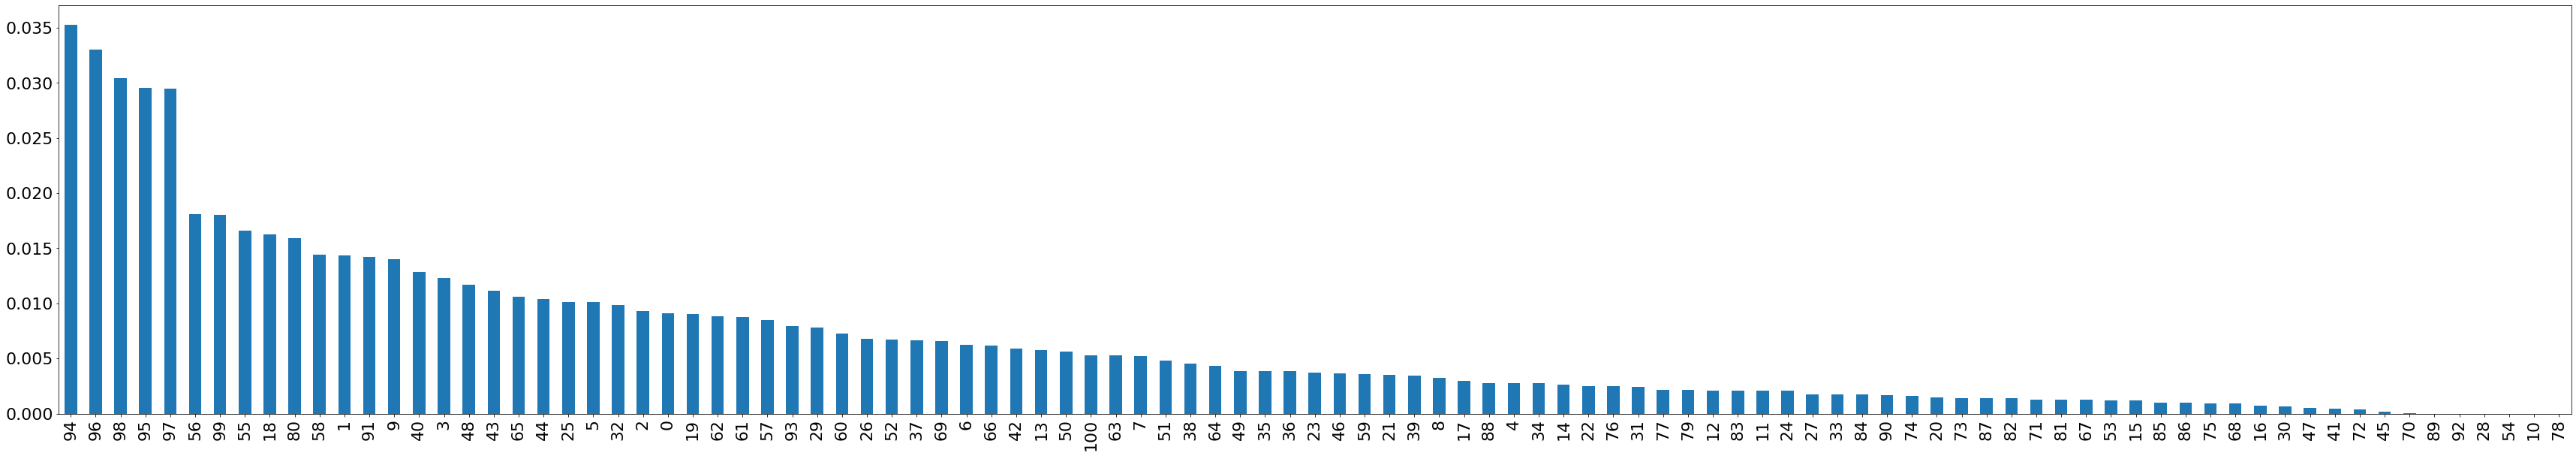

In [73]:

feature_importances.plot.bar(figsize=(60,10))


The second method is the **Chi-square ranking**. The Chi-square test is very similar to the mutual information algorithm in the sense that it measures the dependency between the features and the classification values. 

TODO: **HOW TO INTERPRET CHI2 RESULTS?**

In [74]:
from sklearn.feature_selection import chi2
chi_stats, p_values = chi2(X_train, y_train_encoded)
print(p_values)

[0.00000000e+000 0.00000000e+000 5.52121960e-032 2.14263314e-021
 6.43697914e-166 0.00000000e+000 1.44436738e-283 0.00000000e+000
 1.11199246e-148 0.00000000e+000 1.44008417e-068 1.42179562e-080
 3.59170791e-113 0.00000000e+000 5.14608089e-109 3.76544586e-075
 1.28794654e-229 6.90982456e-128 0.00000000e+000 0.00000000e+000
 2.42676326e-083 3.49748704e-240 4.27284450e-165 0.00000000e+000
 9.50134562e-103 0.00000000e+000 1.09539346e-225 1.09084385e-101
 1.35893350e-066 0.00000000e+000 7.82108792e-076 2.36676103e-187
 0.00000000e+000 1.99727281e-143 6.31802886e-033 0.00000000e+000
 1.37178918e-088 0.00000000e+000 2.83353348e-274 7.95412554e-309
 0.00000000e+000 1.22376900e-078 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.42295759e-132 3.21755544e-240 4.35199497e-073
 0.00000000e+000 4.29227124e-122 1.70003199e-240 3.34508187e-199
 0.00000000e+000 2.95895734e-069 4.22937931e-039 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 3.36146734e-213
 0.00000000e+000 0.000000

### Embedded Method

**Random Forest Importance** Allows us to identify features that have the most polarizing effect in the tree splits. They are the features that categorize the output the most.

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
#use hyperparams of random forest here...
RF =  RandomForestClassifier(n_estimators=340, class_weight='balanced')
RF.fit(X_train, y_train_encoded)

RandomForestClassifier(class_weight='balanced', n_estimators=340)

#### Plotting

feature 97    0.096415
feature 96    0.093651
feature 98    0.093335
feature 95    0.093303
feature 92    0.085352
                ...   
feature 74    0.000108
feature 72    0.000103
feature 70    0.000098
feature 78    0.000097
feature 89    0.000088
Length: 101, dtype: float64


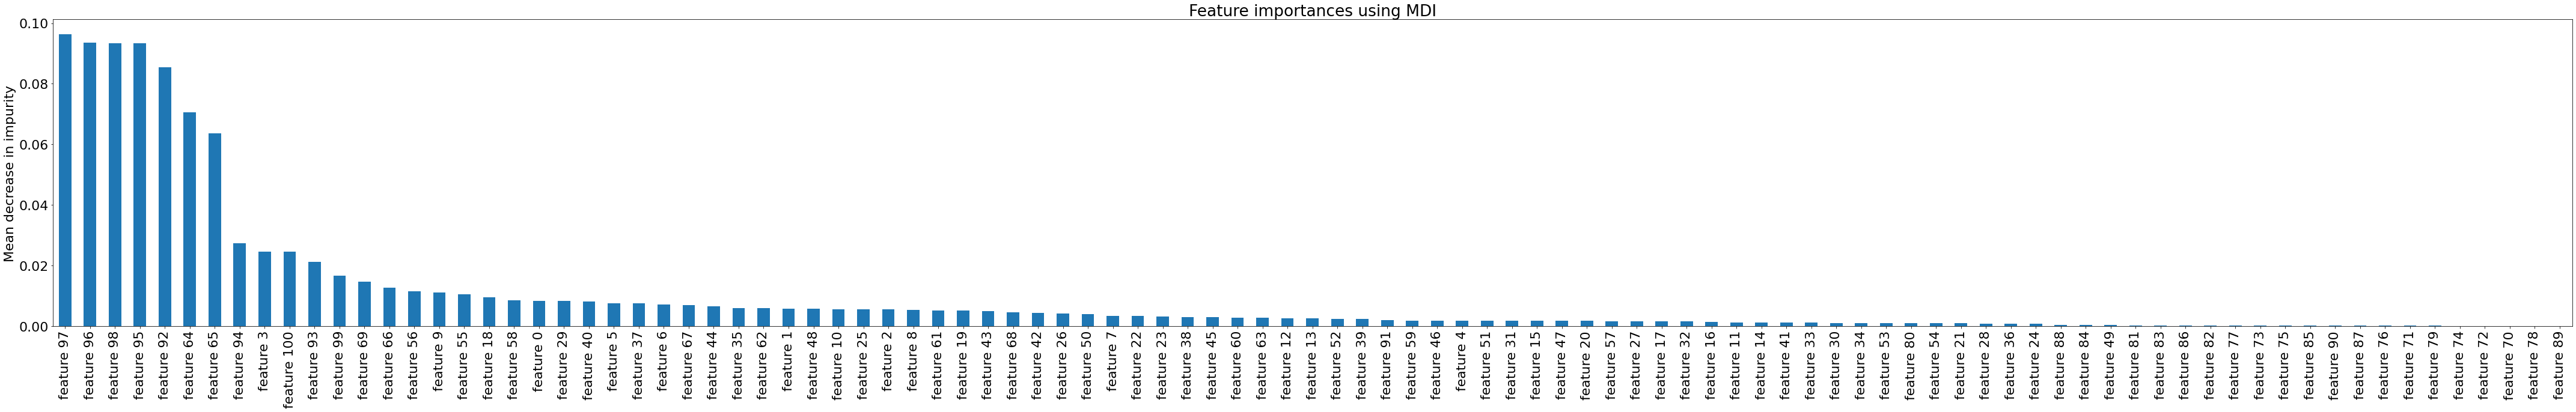

In [ ]:
feature_n = [f"feature {i}" for i in range(X_train.shape[1])]
importances = RF.feature_importances_
RF_df = pd.Series(importances, index=feature_n)
RF_df.sort_values(ascending=False, inplace=True)
print(RF_df)


fig, ax = plt.subplots()
RF_df.plot.bar(ax=ax, figsize=(60,10))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

##TODO map the feature numbers to the length of one hot encodings to reverse engineer which starting features are more meaningful? or simple drop the features with lower importanace...

## Model Fitting

In [ ]:
knn.fit(X_train, y_train_encoded)

# Predictions & Metrics

In [ ]:
y_eval_pred = knn.predict(X_eval)

In [ ]:
y_eval_pred

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc = f1_score(y_eval_encoded, y_eval_pred, average=None)

print(acc)

In [ ]:
acc = f1_score(y_eval_encoded, y_eval_pred, average='micro')
print(acc)

In [ ]:
from sklearn.metrics import classification_report

print(dict(zip(le.classes_, le.transform(le.classes_))))
print(classification_report(y_eval_encoded, y_eval_pred))

# Test Predictions

In [ ]:
y_pred_test = knn.predict(X_test)

In [ ]:
y_pred_test = le.inverse_transform(y_pred_test)

In [ ]:
y_pred_test

array(['Best Concert Ever', 'Enjoyed', 'Enjoyed', ..., 'Enjoyed',
       'Did Not Enjoy', 'Worst Concert Ever'], dtype=object)

In [ ]:
ids_test.values

array(['ConcertExperience_70055', 'ConcertExperience_34799',
       'ConcertExperience_100410', ..., 'ConcertExperience_197434',
       'ConcertExperience_166029', 'ConcertExperience_24025'],
      dtype=object)

In [ ]:
df_soumission = pd.DataFrame({'Id' : ids_test.values, 'Predicted' : y_pred_test})

In [ ]:
df_soumission.to_csv('Soumission3.csv', index=False)